In [1]:
from IPython.core.display import HTML
import requests
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import datetime
import seaborn as sns
from dateutil import parser
import pytz
import pylab as pl
from pyquery import PyQuery as pq
import numpy as np
import scipy
import pandas as pd
from lxml import etree
import os
from os import path
from pprint import pprint
import dateutil
import json
import csv
%matplotlib inline

## Load Data and Preprocessing

In [2]:
df = pd.read_csv('records-all-with-info.csv',encoding='utf-8')
df_member = pd.read_csv('member.csv', encoding='utf-8')
df_party_to_camp_mapping = pd.read_csv('party-to-camp-mapping-en.csv',encoding='utf-8')

In [3]:
from datetime import date
def dateall(x):
    if '/' in x:
        return date(int(x.split('/')[2]), int(x.split('/')[1]), int(x.split('/')[0]))
    else:
        return date(int(x.split('-')[2]), int(x.split('-')[1]), int(x.split('-')[0]))
                    
df['date'] = df['vote-date'].apply(dateall)
                    
df['datetime'] = df['date'].apply(lambda d: datetime.datetime(*d.timetuple()[:7]))

def date2(x):
    if '/' in x:
        return x.split('/')[2]
    else:
        return x.split('-')[2]

def date1(x):
    if '/' in x:
        return x.split('/')[1]
    else:
        return x.split('-')[1]

def date0(x):
    if '/' in x:
        return x.split('/')[0]
    else:
        return x.split('-')[0]

df['year'] = df['vote-date'].apply(date2)
df['month'] = df['vote-date'].apply(date1)
df['day'] = df['vote-date'].apply(date0)

## Basic Statistics

### Overview of data table


In [4]:
print('Total number of voting records:')
print(len(df))

Total number of voting records:
27426


### Time distribution of votes

d:\program files\python\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  """Entry point for launching an IPython kernel.


Text(0.5,1,'Vote Number by Time (per Week)')

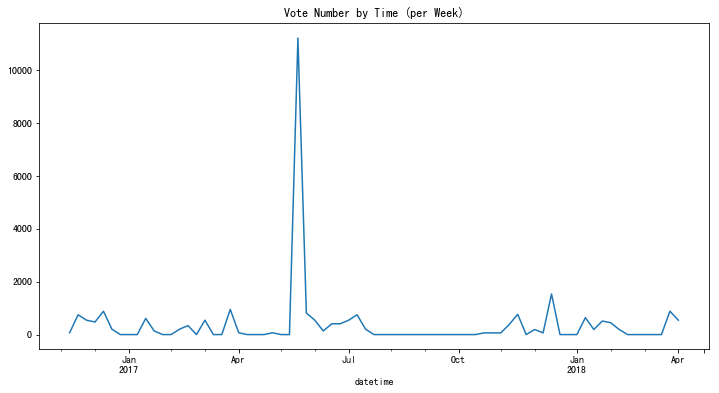

In [5]:
df.set_index('datetime').resample('1w', how='count')['topic_id'].plot(figsize=(12, 6))
plt.title('Vote Number by Time (per Week)')

d:\program files\python\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  """Entry point for launching an IPython kernel.


Text(0.5,1,'Vote Number by Time (per Day)')

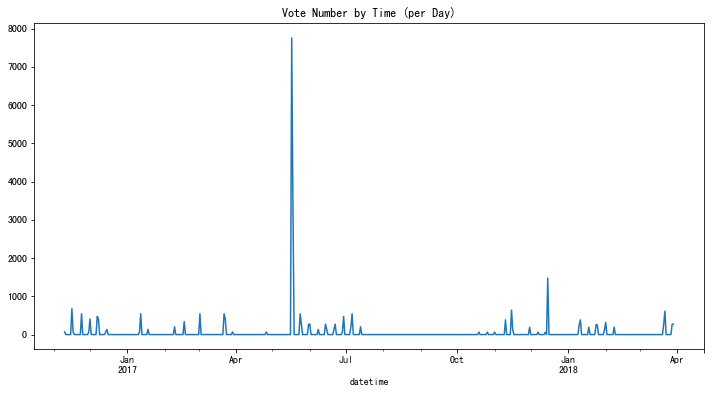

In [6]:
df.set_index('datetime').resample('1d', how='count')['topic_id'].plot(figsize=(12, 6))
plt.title('Vote Number by Time (per Day)')

d:\program files\python\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  """Entry point for launching an IPython kernel.


Text(0.5,1,'Vote Number by Time (per Month)')

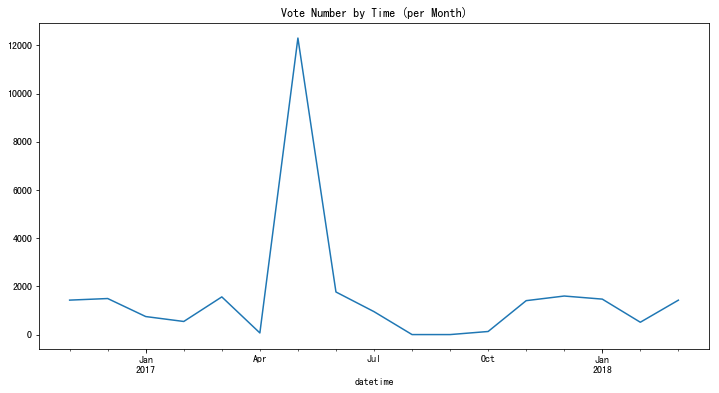

In [7]:
df.set_index('datetime').resample('1m', how='count')['topic_id'].plot(figsize=(12, 6))
plt.title('Vote Number by Time (per Month)')

* 5月的投票數量最多，因為5月份立法會必須要通過香港政府的年度財政預算案

### Voter Statistics

In [8]:
df_vote_type_count = pd.pivot_table(df,
               values='topic_id', index='name-en', columns='vote', aggfunc='count')
df_vote_type_count['total'] = df_vote_type_count.sum(axis=1)

In [9]:
print('Total value counts:')
df_vote_type_count['total'].value_counts()

Total value counts:


408.0    64
307.0     4
21.0      4
1.0       2
Name: total, dtype: int64

In [10]:
df_vote_type_count.sort_values(by='Absent', ascending=False)[:5]

vote,Absent,Abstain,No,Present,Yes,total
name-en,,,,,,
Abraham SHEK,260.0,4.0,106.0,1.0,37.0,408.0
Dennis KWOK,249.0,9.0,40.0,NaN,110.0,408.0
Prof Joseph LEE,229.0,10.0,37.0,1.0,131.0,408.0
HUI Chi-fung,228.0,12.0,39.0,7.0,122.0,408.0
Kenneth LEUNG,228.0,12.0,39.0,NaN,129.0,408.0


In [11]:
df_vote_type_count.sort_values(by='Absent')[:5]

vote,Absent,Abstain,No,Present,Yes,total
name-en,,,,,,
YAU Wai-ching,1.0,NaN,NaN,NaN,NaN,1.0
Sixtus LEUNG,1.0,NaN,NaN,NaN,NaN,1.0
Ir Dr LO Wai-kwok,6.0,18.0,272.0,NaN,112.0,408.0
Tony TSE,8.0,3.0,2.0,NaN,8.0,21.0
AU Nok-hin,9.0,NaN,4.0,NaN,8.0,21.0


## Voting Preference Analysis


In [12]:
def get_vote_value2(v):
    if v == 'Absent':
        return 0
    elif v == 'Yes':
        return 1
    else:
        # No, Abstain, Present are effectively "No"
        return -1
    
def get_vote_value(v):
    if v == 'Yes':
        return 1
    elif v == 'No':
        return -1
    else:
        # No, Abstain, Present are effectively "No"
        return 0

df['vote-value'] = df['vote'].apply(get_vote_value)

In [13]:
def get_pc1_from_df(df):
    df_matrix = pd.DataFrame(index=df['name-en'].unique())
    for gn, g in df.groupby('topic_id'):
        df_matrix[gn] = g.set_index('name-en')['vote-value']
    
    df_matrix.fillna(0)
    def clean_values(x):
        x[(x != 1) & (x != -1)] = 0
    df_matrix.apply(clean_values)
    
    X = np.matrix(df_matrix.fillna(0).as_matrix()).astype('float')
    X = X - np.mean(X, 0)
 
    from sklearn.decomposition import PCA
    pca = PCA(n_components=1)
    # X is of dimensions: n_samples x n_features
    X_reduced = pca.fit_transform(X)
    df_pc1 = pd.DataFrame(-X_reduced, index=df_matrix.index, columns=['PC1'])
    df_pc1 = df_pc1.sort_values('PC1')#,ascending = False)
    return df_pc1

### 2016 to 2018 All Votes

In [14]:
pc1 = get_pc1_from_df(df)

In [15]:
pc1['rank'] = pc1.rank()
pc1_plot = pc1.reset_index()

def scale_to(series, length):
    return series * length / (series.max() - series.min())

#pc1_plot['PC1'] = scale_to(pc1_plot['PC1'], 500)

There are only pro-establishment & pan-democracy in the input data of member info.


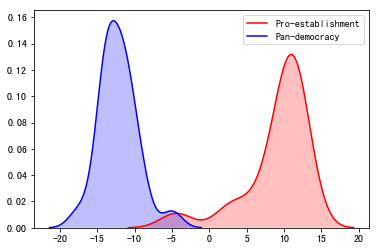

In [16]:
df_pc1_member = pd.merge(pc1_plot, df_member, left_on='index', right_on='Name-Chi')
ax = sns.kdeplot(df_pc1_member[df_pc1_member['Political Camp'] == 'Pro-establishment'].rename(
        columns={'PC1': 'Pro-establishment'})['Pro-establishment'], color='r', shade=True)
ax = sns.kdeplot(df_pc1_member[df_pc1_member['Political Camp'] == 'Pan-democracy'].rename(
        columns={'PC1': 'Pan-democracy'})['Pan-democracy'], color='b', shade=True)
print('There are only pro-establishment & pan-democracy in the input data of member info.')

Text(0.5,1,'Voting Preference by Camp')

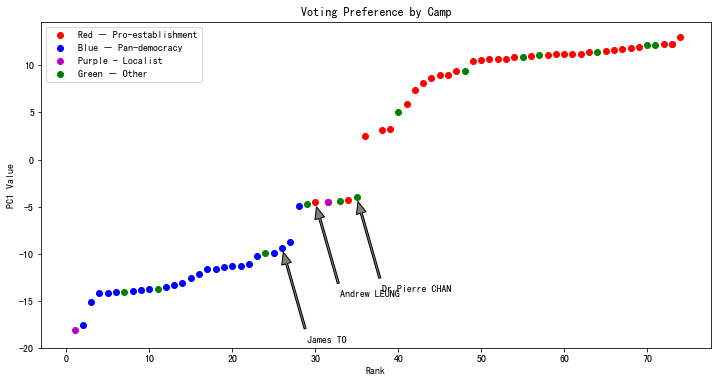

In [17]:
plt.figure(figsize=(12, 6))
df_selected_members = df_pc1_member[df_pc1_member['Political Camp'] == 'Pro-establishment']
ax1 = plt.scatter(list(df_selected_members['rank'].values), list(df_selected_members['PC1'].values), color='r')
df_selected_members = df_pc1_member[df_pc1_member['Political Camp'] == 'Pan-democracy']
ax2 = plt.scatter(list(df_selected_members['rank'].values), list(df_selected_members['PC1'].values), color='b')
df_selected_members = df_pc1_member[df_pc1_member['Political Camp'] == 'Localist']
ax3 = plt.scatter(list(df_selected_members['rank'].values), list(df_selected_members['PC1'].values), color='m')
df_selected_members = df_pc1_member[
        (df_pc1_member['Political Camp'] != 'Pan-democracy') &
        (df_pc1_member['Political Camp'] != 'Pro-establishment')&
        (df_pc1_member['Political Camp'] != 'Localist')
]
ax4 = plt.scatter(list(df_selected_members['rank'].values), list(df_selected_members['PC1'].values), color='g')

plt.legend([ax1, ax2, ax3, ax4], ['Red － Pro-establishment', 'Blue － Pan-democracy','Purple - Localist', 'Green － Other'], loc='upper left')

for (i, row) in df_pc1_member.iterrows():
    if row['index'] in set([
            'TAM Yiu-chung',
            'Andrew LEUNG',
            'Dr Pierre CHAN',
            'James TO'
        ]):
        plt.annotate(row['index'], 
                     xy=(row['rank'], row['PC1']),
                     xytext=(row['rank'] + 3, row['PC1'] - 10),
                     arrowprops=dict(facecolor='grey', headwidth=10, width=2, shrink=0.05))


plt.xlabel('Rank')
plt.ylabel('PC1 Value')
plt.title('Voting Preference by Camp')

* 梁君彦是主席，在最中间，在他周围的，YAU Wai-ching	遊蕙禎 Sixtus LEUNG梁頌恒 是直接被取消资格的，Tony TSE謝偉銓Vincent CHENG鄭泳舜是新补选的议员（在梁君彦下方），AU Nok-hin區諾軒Gary FAN范國威 也是新补选的（在梁君彦上方），非被取消和补选的人，离梁君彦最近的是Dr Pierre CHAN陳沛然 和James TO塗謹申

* 從相對距離上來看，泛民陣營整體離梁君彦更近，而建制則離得較遠。圖像顯示，建制派整體而言在投票中表現得比泛民更加激進。即建制派的建制立場，要強過泛民的民主立場

In [18]:
pc1_plot[(pc1_plot['rank'] > 25) & (pc1_plot['rank'] < 36)]

,index,PC1,rank
25,James TO,-9.363843,26.0
26,Dr YIU Chung-yim,-8.773588,27.0
27,Gary FAN,-4.983943,28.0
28,AU Nok-hin,-4.696072,29.0
29,Andrew LEUNG,-4.548081,30.0
30,Sixtus LEUNG,-4.548081,31.5
31,YAU Wai-ching,-4.548081,31.5
32,Tony TSE,-4.371636,33.0
33,Vincent CHENG,-4.292477,34.0
34,Dr Pierre CHAN,-3.995818,35.0


In [19]:
df[df['name-en']=='Andrew LEUNG']['vote'].value_counts()  #梁君彦的投票记录 

Present    397
Absent      11
Name: vote, dtype: int64

In [20]:
df[df['name-en']=='Dr Pierre CHAN']['vote'].value_counts()  #陳沛然的投票记录

Absent     178
Yes        142
No          65
Abstain     23
Name: vote, dtype: int64

In [21]:
df[df['name-en']=='James TO']['vote'].value_counts() #塗謹申的投票记录

Absent     214
Yes        127
No          41
Present     19
Abstain      7
Name: vote, dtype: int64

Text(0.5,1,'Voting Preference by Camp')

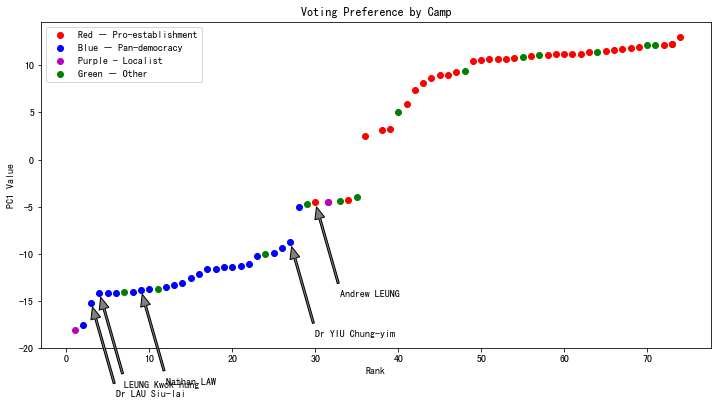

In [22]:
plt.figure(figsize=(12, 6))
df_selected_members = df_pc1_member[df_pc1_member['Political Camp'] == 'Pro-establishment']
ax1 = plt.scatter(list(df_selected_members['rank'].values), list(df_selected_members['PC1'].values), color='r')
df_selected_members = df_pc1_member[df_pc1_member['Political Camp'] == 'Pan-democracy']
ax2 = plt.scatter(list(df_selected_members['rank'].values), list(df_selected_members['PC1'].values), color='b')
df_selected_members = df_pc1_member[df_pc1_member['Political Camp'] == 'Localist']
ax3 = plt.scatter(list(df_selected_members['rank'].values), list(df_selected_members['PC1'].values), color='m')
df_selected_members = df_pc1_member[
        (df_pc1_member['Political Camp'] != 'Pan-democracy') &
        (df_pc1_member['Political Camp'] != 'Pro-establishment')&
        (df_pc1_member['Political Camp'] != 'Localist')
]
ax4 = plt.scatter(list(df_selected_members['rank'].values), list(df_selected_members['PC1'].values), color='g')

plt.legend([ax1, ax2, ax3, ax4], ['Red － Pro-establishment', 'Blue － Pan-democracy','Purple - Localist', 'Green － Other'], loc='upper left')

for (i, row) in df_pc1_member.iterrows():
    if row['index'] in set([
            'Dr YIU Chung-yim',
            'Andrew LEUNG',
            'Dr LAU Siu-lai',
            'Nathan LAW',
            'LEUNG Kwok-hung'
        ]):
        plt.annotate(row['index'], 
                     xy=(row['rank'], row['PC1']),
                     xytext=(row['rank'] + 3, row['PC1'] - 10),
                     arrowprops=dict(facecolor='grey', headwidth=10, width=2, shrink=0.05))


plt.xlabel('Rank')
plt.ylabel('PC1 Value')
plt.title('Voting Preference by Camp')

* 劉小麗 梁國雄 在2017年7月14日而被取消議員資格，投票结果仍处于泛民主派的极端
* 同一时期被取消资格的羅冠聰、姚松炎，投票意向则较为中间

Text(0.5,1,'Voting Preference by Camp')

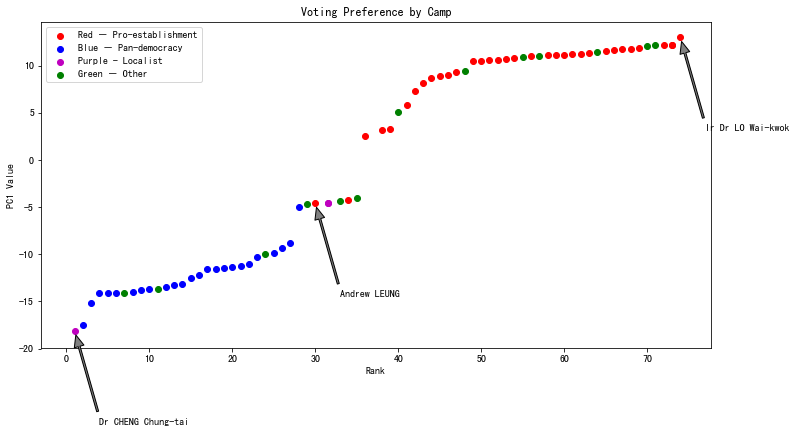

In [23]:
plt.figure(figsize=(12, 6))
df_selected_members = df_pc1_member[df_pc1_member['Political Camp'] == 'Pro-establishment']
ax1 = plt.scatter(list(df_selected_members['rank'].values), list(df_selected_members['PC1'].values), color='r')
df_selected_members = df_pc1_member[df_pc1_member['Political Camp'] == 'Pan-democracy']
ax2 = plt.scatter(list(df_selected_members['rank'].values), list(df_selected_members['PC1'].values), color='b')
df_selected_members = df_pc1_member[df_pc1_member['Political Camp'] == 'Localist']
ax3 = plt.scatter(list(df_selected_members['rank'].values), list(df_selected_members['PC1'].values), color='m')
df_selected_members = df_pc1_member[
        (df_pc1_member['Political Camp'] != 'Pan-democracy') &
        (df_pc1_member['Political Camp'] != 'Pro-establishment')&
        (df_pc1_member['Political Camp'] != 'Localist')
]
ax4 = plt.scatter(list(df_selected_members['rank'].values), list(df_selected_members['PC1'].values), color='g')

plt.legend([ax1, ax2, ax3, ax4], ['Red － Pro-establishment', 'Blue － Pan-democracy','Purple - Localist', 'Green － Other'], loc='upper left')

for (i, row) in df_pc1_member.iterrows():
    if row['index'] in set([
        'Ir Dr LO Wai-kwok',
        'Andrew LEUNG',
        'Dr CHENG Chung-tai'
        ]):
        plt.annotate(row['index'], 
                     xy=(row['rank'], row['PC1']),
                     xytext=(row['rank'] + 3, row['PC1'] - 10),
                     arrowprops=dict(facecolor='grey', headwidth=10, width=2, shrink=0.05))


plt.xlabel('Rank')
plt.ylabel('PC1 Value')
plt.title('Voting Preference by Camp')

* 根據投票記錄得出的两个极端， 鄭松泰 vs 盧偉國

In [24]:
same = []
different = []
for i in range(0,len(df[df['name-en']=='Ir Dr LO Wai-kwok']['vote-value'])):
    if df[df['name-en']=='Ir Dr LO Wai-kwok']['vote-value'].values[i] == df[df['name-en']=='Dr CHENG Chung-tai']['vote-value'].values[i]:
        same.append(df[df['name-en']=='Ir Dr LO Wai-kwok']['motion-ch'].values[i])
    else:
        different.append(df[df['name-en']=='Ir Dr LO Wai-kwok']['motion-ch'].values[i])

* 鄭松泰 vs 盧偉國 投票意見相同的議案：

In [25]:
same  

['吳永嘉議員對黃國健議員的「取消強制性公積金對沖機制」議案作出的修正案',
 '陳恒鑌議員對梁美芬議員的「促請政府修改《消防安全(建築物)條例》」議案作出的修正案',
 '柯創盛議員對謝偉俊議員的「制訂房屋政策\u3000紓緩殷切住屋需求」議案作出的修正案',
 '麥美娟議員對陳恒鑌議員的「更新《香港規劃標準與準則》及增加社區設施以優化生活環境」議案作出的修正案',
 '盧偉國議員對陳恒鑌議員就「更新《香港規劃標準與準則》及增加社區設施以優化生活環境」所提，經麥美娟議員修正的議案，作出的修正案',
 '易志明議員對陳恒鑌議員就「更新《香港規劃標準與準則》及增加社區設施以優化生活環境」所提，經麥美娟議員及盧偉國議員修正的議案，作出的修正案',
 '陳恒鑌議員動議，經麥美娟議員、盧偉國議員、易志明議員及尹兆堅議員修正的「更新《香港規劃標準與準則》及增加社區設施以優化生活環境」議案',
 '李慧琼議員對郭偉强議員的「對下任行政長官的期望」議案作出的修正案',
 '縮短點名表決響鐘時間的議案',
 '田北辰議員對張宇人議員就「積極研究成立中產事務委員會」所提，經易志明議員、郭偉强議員及葛珮帆議員修正的議案，作出的修正案',
 '《2017年撥款條例草案》 - 全體委員會審議階段 - 總目94的修正案 (修正案編號81)',
 '邵家輝議員就修\u200d訂《2017年吸煙(公眾衞生)(公告)(修訂)令》而動議的第一項擬議決議案',
 '張超雄議員就修\u200d訂《2017年吸煙(公眾衞生)(公告)(修訂)令》而動議的擬議決議案',
 '邵家輝議員就修\u200d訂《2017年吸煙(公眾衞生)(公告)(修訂)令》而動議的第二項擬議決議案',
 '邵家輝議員就修\u200d訂《2017年吸煙(公眾衞生)(公告)(修訂)令》而動議的第三項擬議決議案',
 '《2017年稅務(修訂)(第2號)條例草案》 - 全體委員會審議階段 - 運輸及房屋局局長的修正案 - 第4、8及10條',
 '譚文豪議員對鄺俊宇議員就「維護動物權益」所提，經梁美芬議員修正的議案，作出的修正案',
 '環境局局長根據《產品環保責任條例》及《釋義及通則條例》動議的擬議決議案',
 '盧偉國議員對莫乃光議員就「革新過時法例，促進創新科技發展」所提，經容海恩議員修正的議案，作出的修正案',
 '梁志祥議員對梁

* 鄭松泰 vs 盧偉國 投票意見相反的議案：

In [26]:
different 

['根據《立法會(權力及特權)條例》動議的議案',
 '蔣麗芸議員對黃國健議員的「取消強制性公積金對沖機制」議案作出的修正案',
 '尹兆堅議員對黃國健議員的「取消強制性公積金對沖機制」議案作出的修正案',
 '張超雄議員對黃國健議員的「取消強制性公積金對沖機制」議案作出的修正案',
 '劉小麗議員對黃國健議員的「取消強制性公積金對沖機制」議案作出的修正案',
 '田北辰議員對黃國健議員的「取消強制性公積金對沖機制」議案作出的修正案',
 '「取消強制性公積金對沖機制」議案',
 '葉建源議員對張國鈞議員的「規定初中中國歷史獨立成科」議案作出的修正案',
 '葉劉淑儀議員對張國鈞議員的「規定初中中國歷史獨立成科」議案作出的修正案',
 '張國鈞議員動議，經葉劉淑儀議員修正的「規定初中中國歷史獨立成科」議案',
 '邵家輝議員對容海恩議員的「力促市場健康競爭，制衡領展獨大局面」議案作出的修正案',
 '尹兆堅議員對容海恩議員的「力促市場健康競爭，制衡領展獨大局面」議案作出的修正案',
 '柯創盛議員對容海恩議員就「力促市場健康競爭，制衡領展獨大局面」所提，經尹兆堅議員修正的議案，作出的修正案',
 '張超雄議員對容海恩議員就「力促市場健康競爭，制衡領展獨大局面」所提，經尹兆堅議員修正的議案，作出的修正案',
 '容海恩議員動議，經尹兆堅議員修正的「力促市場健康競爭，制衡領展獨大局面」議案',
 '張超雄議員對劉國勳議員的「強化區議會的角色及職能」議案作出的修正案',
 '胡志偉議員對劉國勳議員的「強化區議會的角色及職能」議案作出的修正案',
 '許智峯議員對劉國勳議員就「強化區議會的角色及職能」所提，經胡志偉議員修正的議案，作出的修正案',
 '張華峰議員動議，經涂謹申議員修正的「制訂全面上巿政策」議案',
 '何啟明議員對周浩鼎議員的「打擊‘假難民’」議案作出的修正案',
 '縮短點名表決響鐘時間的議案',
 '容海恩議員對周浩鼎議員就「打擊‘假難民’」所提，經何啟明議員修正的議案，作出的修正案',
 '梁美芬議員對周浩鼎議員就「打擊‘假難民’」所提，經何啟明議員修正的議案，作出的修正案',
 '周浩鼎議員動議，經何啟明議員修正的「打擊‘假難民’」議案',
 '根據《議事規則》第90(2)條，動議拒絕給予許可的議案',
 '郭偉强議員對謝偉俊議員的「制訂房屋政策\u

In [27]:
len(same)

37

In [28]:
len(different)

371

There are only pro-establishment & pan-democracy in the input data of member info.


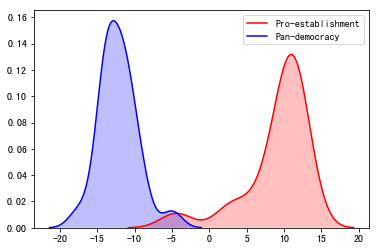

In [29]:
df_pc1_member = pd.merge(pc1_plot, df_member, left_on='index', right_on='Name-Chi')
ax = sns.kdeplot(df_pc1_member[df_pc1_member['Political Camp'] == 'Pro-establishment'].rename(
        columns={'PC1': 'Pro-establishment'})['Pro-establishment'], color='r', shade=True)
ax = sns.kdeplot(df_pc1_member[df_pc1_member['Political Camp'] == 'Pan-democracy'].rename(
        columns={'PC1': 'Pan-democracy'})['Pan-democracy'], color='b', shade=True)
#ax = sns.kdeplot(df_pc1_member[df_pc1_member['Political Camp'] == 'Localist'].rename(
        #columns={'PC1': 'Localist'})['Localist'], color='m', shade=True)
print('There are only pro-establishment & pan-democracy in the input data of member info.')

### 2016-2018 Scatter Plot By Type

Text(0.5,1,'Voting Preference by Constituency Type')

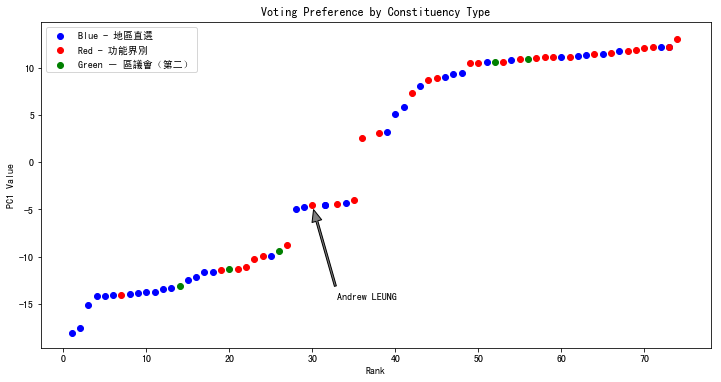

In [30]:
plt.figure(figsize=(12, 6))
df_selected_members = df_pc1_member[df_pc1_member['地區'] == '地區直選']
ax1 = plt.scatter(list(df_selected_members['rank'].values), list(df_selected_members['PC1'].values), color='b')
df_selected_members = df_pc1_member[df_pc1_member['地區'] == '功能界別']
ax2 = plt.scatter(list(df_selected_members['rank'].values), list(df_selected_members['PC1'].values), color='r')
df_selected_members = df_pc1_member[df_pc1_member['地區'] == '區議會（第二）']
ax3 = plt.scatter(list(df_selected_members['rank'].values), list(df_selected_members['PC1'].values), color='g')

plt.legend([ax1, ax2, ax3], ['Blue - 地區直選', 
                             'Red - 功能界別', 
                             'Green － 區議會（第二）'], loc='upper left')

for (i, row) in df_pc1_member.iterrows():
    if row['index'] in set([
            'Andrew LEUNG'
        ]):
        plt.annotate(row['index'], 
                     xy=(row['rank'], row['PC1']),
                     xytext=(row['rank'] + 3, row['PC1'] - 10),
                     arrowprops=dict(facecolor='grey', headwidth=10, width=2, shrink=0.05))


plt.xlabel('Rank')
plt.ylabel('PC1 Value')
plt.title('Voting Preference by Constituency Type')

* 結合之前的圖，大多數功能組別的議員屬建制派。另外，泛民派多數議員來自地區或「區議會第二」選舉

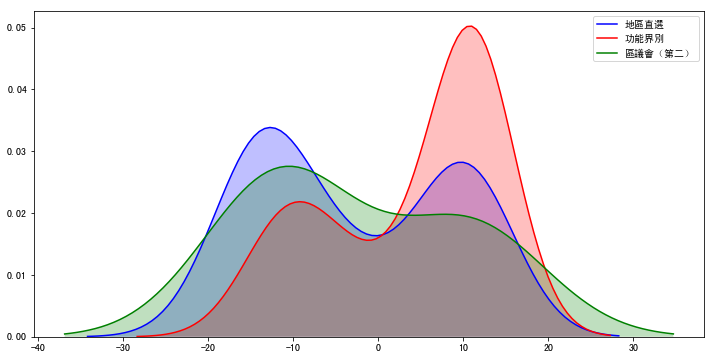

In [31]:
plt.figure(figsize=(12, 6))
df_pc1_member = pd.merge(pc1_plot, df_member, left_on='index', right_on='Name-Chi')
ax = sns.kdeplot(df_pc1_member[df_pc1_member['地區'] == '地區直選'].rename(
        columns={'PC1': '地區直選'})['地區直選'], color='b', shade=True)
ax = sns.kdeplot(df_pc1_member[df_pc1_member['地區'] == '功能界別'].rename(
        columns={'PC1': '功能界別'})['功能界別'], color='r', shade=True)
ax = sns.kdeplot(df_pc1_member[df_pc1_member['地區'] == '區議會（第二）'].rename(
        columns={'PC1': '區議會（第二）'})['區議會（第二）'], color='g', shade=True)

### 2016 - 2018 Scatter Plot by Party

In [32]:
df_party_to_camp_mapping['Political Camp'].value_counts()

Pan-democracy        12
Pro-establishment     8
Localist              2
Other                 1
Name: Political Camp, dtype: int64

In [33]:
camp_color = {
    'Pan-democracy': 'b',
    'Pro-establishment': 'r',
    'Localist':'m',
    'Other': 'g',
}

In [34]:
df_pc1_member['所屬團體-finalized'].fillna('獨立').value_counts().sum()

74

d:\program files\python\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
d:\program files\python\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Text(0,0.5,'Party')

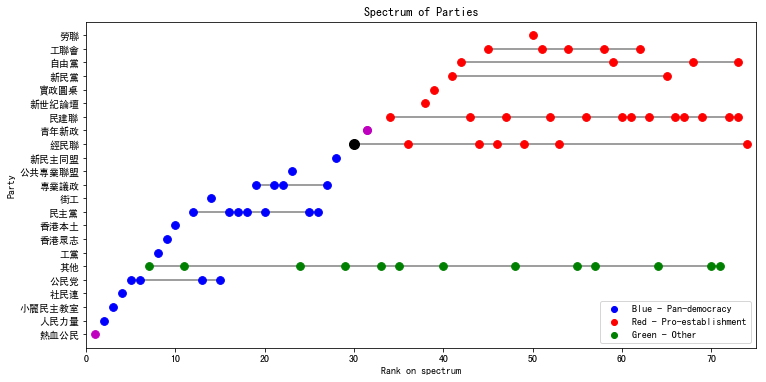

In [35]:
plt.figure(figsize=(12, 6))
idx = 0
parties = []

def party_ordering_func(group_tuple):
    gname, group = group_tuple
    if gname == 'Other':
        return -1
    else:
        return group['rank'].min()
    
for (gname, group) in sorted(list(df_pc1_member.fillna('其他').groupby('所屬團體-finalized')),
                            key=party_ordering_func):
    if gname == 'Other':
        color = camp_color['Other']
    else:
        color = camp_color[
            df_party_to_camp_mapping.set_index('Party').ix[gname].values[0]
        ]
    if gname != 'Other':
        ax = plt.plot([group['rank'].min(), group['rank'].max()], [idx, idx], 
                      color='grey',
                      zorder=1)
    
    parties.append(gname)
    ax = plt.scatter(
        list(group['rank'].values), 
        [idx] * len(group), 
        color=color,
        marker='o',
        s=60,
        zorder=2,
    )
    #print(group['index'])
    if 'Andrew LEUNG' in group['index'].values:
        #print('y')
        plt.scatter(
            [group.set_index('index').ix['Andrew LEUNG']['rank']],
            [idx],
            color='k',
            s=100,
            zorder=2,
        )
    idx += 1
    
plt.title('Party Voting Preference Distribution')
plt.yticks(range(0, len(parties)), parties)
plt.axis([0, 75, -1, len(parties)])

#plt.legend([ax1, ax2, ax3, ax4], ['Red － Pro-establishment', 'Blue － Pan-democracy','Purple - Localist', 'Green － Other'], loc='lower right')
plt.legend([ax1, ax2, ax3], [ 'Blue - Pan-democracy', 'Red - Pro-establishment','Green - Other'], loc='lower right')

plt.title('Spectrum of Parties')
plt.xlabel('Rank on spectrum')
plt.ylabel('Party')


* 佔有五個及以上議席的政黨： 民建聯（13席）、經民聯（7席）、民主黨（6席）、工聯會（5席）
* 建制派和泛民主派有明顯的投票傾向差異
* 相較于泛民主派黨派，建制派黨派內部的意見差別較大，其中民建聯和經民聯是意見最撕裂的政黨

###  Time Vavriance Analysis, KDE 2 years, (All motions)

In [36]:
df_matrix = pd.DataFrame(index=df['name-en'].unique())
for gn, g in df.groupby('topic_id'):
    df_matrix[gn] = g.set_index('name-en')['vote-value']

df_matrix = df_matrix.fillna(0)
def clean_values(x):
    x[(x != 1) & (x != -1)] = 0
df_matrix.apply(clean_values)

#TODO:
#    Check why we need fillna(0) here?
#    There may be some missing records from the input
X = np.matrix(df_matrix.as_matrix()).astype('float')
X = X - np.mean(X, 0)

from sklearn.decomposition import PCA
pca_legco_all = PCA(n_components=1)
# X is of dimensions: n_samples x n_features
pca_legco_all.fit(X)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [37]:
np.size(X)

30192

In [38]:
all_votes_mean = np.mean(X, 0)
all_motions = list(df_matrix.columns)
all_voters = list(df_matrix.index)

In [39]:
def construct_matrix_from_dataframe(df_input):
    df_output = pd.DataFrame(
        np.zeros((len(all_voters), len(all_motions))),
        all_voters,
        all_motions
    )
    for gn, g in df_input.groupby('topic_id'):
        df_output[gn] = g.set_index('name-en')['vote-value']
    X_output = np.matrix(df_output.fillna(0).as_matrix()).astype('float')
    X_output = X_output - all_votes_mean
    return X_output

def construct_dataframe_from_pc1_vector(pc1_vector):
    df_pc1 = pd.DataFrame(pc1_vector, index=all_voters, columns=['PC1'])
    df_pc1 = df_pc1.sort_values(by = 'PC1')
    return df_pc1

In [40]:
terms = [
    (date(2016,9,1), date(2017,7,31)),
    (date(2017,9,1), date(2018,7,31))
]

def visualize_a_segment(df, d_begin, d_end):
    df_selected = df[
        (df['date'] > d_begin)
        &
        (df['date'] < d_end)
    ]
    X = construct_matrix_from_dataframe(df_selected)
    X_PC1 = pca_legco_all.transform(X)
    df_pc1 = construct_dataframe_from_pc1_vector(X_PC1)
    df_pc1_member = pd.merge(df_pc1.reset_index(), df_member, left_on='index', right_on='Name-Chi')
    ax = sns.kdeplot(df_pc1_member[df_pc1_member['Political Camp'] == 'Pro-establishment'].rename(
            columns={'PC1': 'Pro-establishment'})['Pro-establishment'], color='r', shade=True)
    ax = sns.kdeplot(df_pc1_member[df_pc1_member['Political Camp'] == 'Pan-democracy'].rename(
            columns={'PC1': 'Pan-democracy'})['Pan-democracy'], color='b', shade=True)
    '''
    ax = sns.kdeplot(df_pc1_member[
            (df_pc1_member['派別'] != '泛民') &
            (df_pc1_member['派別'] != '建制')
        ].rename(columns={'PC1': '其他'})['其他'], color='g', shade=True)
    '''
    plt.title('PC1 KDE from %s to %s' % (d_begin, d_end))
    plt.axis([-15, 30, 0, 0.8])
    return
    #return save_fig_and_show_download_link('pc1-hist-all-motion-%s-%s.svg' % (d_begin, d_end))

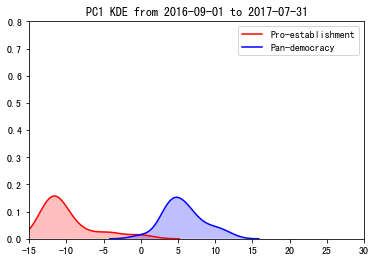

In [41]:
visualize_a_segment(df, terms[0][0], terms[0][1])

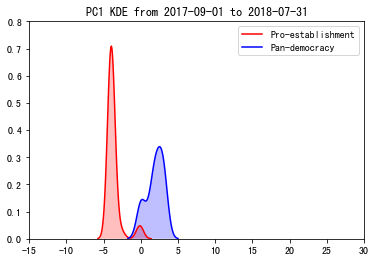

In [42]:
visualize_a_segment(df, terms[1][0], terms[1][1])

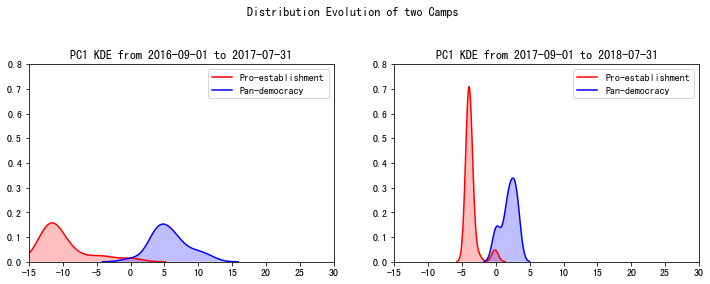

In [43]:
plt.figure(figsize=(12, 8))
plt.suptitle('Distribution Evolution of two Camps')
for i in range(2):
    plt.subplot(2, 2, i+1)
    visualize_a_segment(df, terms[i][0], terms[i][1])

### 2016 - 2018 Only Main Motions (No Amendments)

In [44]:
df_main_motions = df[df['motion-ch'].apply(lambda x: not '修正案' in x)]
print('All motions: %s' % len(df['motion-ch'].value_counts()))
print('Main motions: %s' % len(df_main_motions['motion-ch'].value_counts()))

All motions: 401
Main motions: 118


In [45]:
df_main_motions = df[df['motion-ch'].apply(lambda x: not '修正案' in x)]
pc1 = get_pc1_from_df(df_main_motions)

In [46]:
pc1['rank'] = pc1.rank()
pc1_plot = pc1.reset_index()

def scale_to(series, length):
    return series * length / (series.max() - series.min())


In [47]:
pc1_plot.head()

,index,PC1,rank
0,Alvin YEUNG,-9.158739,1.0
1,Dr CHENG Chung-tai,-9.140278,2.0
2,Andrew WAN,-8.955261,3.0
3,Dr Helena WONG,-8.608654,4.0
4,Charles Peter MOK,-8.458102,5.0


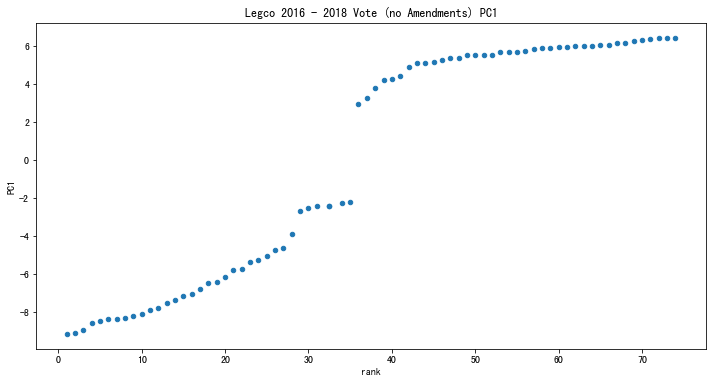

In [48]:
pc1_plot.plot(kind='scatter', x='rank', y='PC1', figsize=(12, 6), title='Legco 2016 - 2018 Vote (no Amendments) PC1')

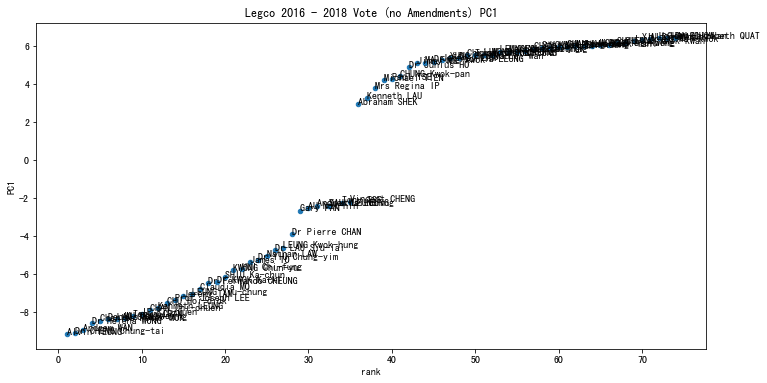

In [49]:
pc1_plot.plot(kind='scatter', x='rank', y='PC1', figsize=(12, 6), title='Legco 2016 - 2018 Vote (no Amendments) PC1')
for (i, row) in pc1_plot.iterrows():
    plt.text(row['rank'], row['PC1'], row['index'])

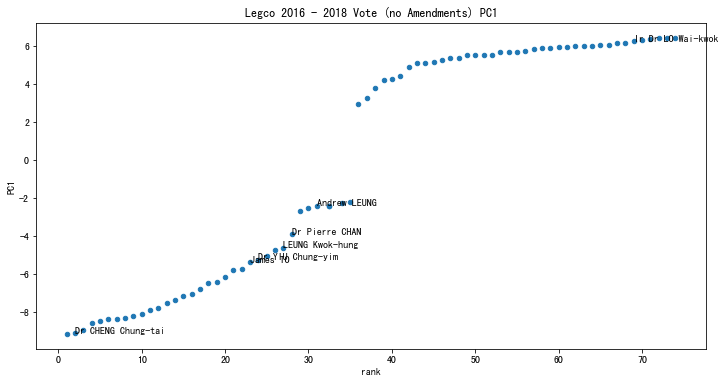

In [50]:
pc1_plot.plot(kind='scatter', x='rank', y='PC1', figsize=(12, 6), title='Legco 2016 - 2018 Vote (no Amendments) PC1')
for (i, row) in pc1_plot.iterrows():
    if row['index'] in set([
          'Andrew LEUNG',
            'LEUNG Kwok-hung',
            'Dr Pierre CHAN',
        'Dr YIU Chung-yim',
        'James TO',
        'Ir Dr LO Wai-kwok',
        'Dr CHENG Chung-tai'
        ]):
        plt.text(row['rank'], row['PC1'], row['index'])


### Time variance analysis

In [51]:
df_matrix = pd.DataFrame(index=df_main_motions['name-en'].unique())
for gn, g in df_main_motions.groupby('topic_id'):
    df_matrix[gn] = g.set_index('name-en')['vote-value']

df_matrix = df_matrix.fillna(0)
def clean_values(x):
    x[(x != 1) & (x != -1)] = 0
df_matrix.apply(clean_values)

#TODO:
#    Check why we need fillna(0) here?
#    There may be some missing records from the input
X = np.matrix(df_matrix.as_matrix()).astype('float')
X = X - np.mean(X, 0)

from sklearn.decomposition import PCA
pca_legco_all = PCA(n_components=1)
# X is of dimensions: n_samples x n_features
pca_legco_all.fit(X)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [52]:
all_votes_mean = np.mean(X, 0)
all_motions = list(df_matrix.columns)
all_voters = list(df_matrix.index)

In [53]:
def construct_matrix_from_dataframe(df_input):
    df_output = pd.DataFrame(
        np.zeros((len(all_voters), len(all_motions))),
        all_voters,
        all_motions
    )
    for gn, g in df_input.groupby('topic_id'):
        df_output[gn] = g.set_index('name-en')['vote-value']
    X_output = np.matrix(df_output.fillna(0).as_matrix()).astype('float')
    X_output = X_output - all_votes_mean
    return X_output

def construct_dataframe_from_pc1_vector(pc1_vector):
    df_pc1 = pd.DataFrame(pc1_vector, index=all_voters, columns=['PC1'])
    df_pc1 = df_pc1.sort_values(by = 'PC1')
    return df_pc1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021C6C294A20>]],
      dtype=object)

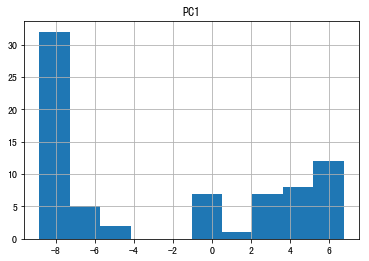

In [54]:
construct_dataframe_from_pc1_vector(
    pca_legco_all.transform(construct_matrix_from_dataframe(df_main_motions))
).hist()


### 2years PC1 histogram

In [55]:
terms = [
    (date(2016,9,1), date(2017,7,31)),
    (date(2017,9,1), date(2018,7,31))
]

def visualize_a_segment(df, d_begin, d_end):
    df_selected = df[
        (df['date'] > d_begin)
        &
        (df['date'] < d_end)
    ]
    X = construct_matrix_from_dataframe(df_selected)
    X_PC1 = pca_legco_all.transform(X)
    df_pc1 = construct_dataframe_from_pc1_vector(X_PC1)
    df_pc1_member = pd.merge(df_pc1.reset_index(), df_member, left_on='index', right_on='Name-Chi')
    ax = sns.kdeplot(df_pc1_member[df_pc1_member['Political Camp'] == 'Pro-establishment'].rename(
            columns={'PC1': 'Pro-establishment'})['Pro-establishment'], color='r', shade=True)
    ax = sns.kdeplot(df_pc1_member[df_pc1_member['Political Camp'] == 'Pan-democracy'].rename(
            columns={'PC1': 'Pan-democracy'})['Pan-democracy'], color='b', shade=True)
    plt.title('PC1 KDE from %s to %s' % (d_begin, d_end))
    plt.axis([-8, 8, 0, 1])
    return 
    #return save_fig_and_show_download_link('pc1-hist-%s-%s.svg' % (d_begin, d_end))

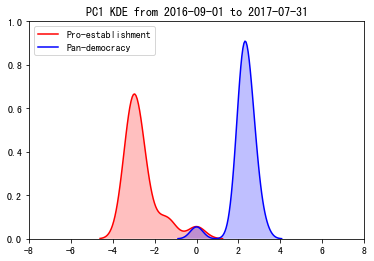

In [56]:
visualize_a_segment(df_main_motions, terms[0][0], terms[0][1])

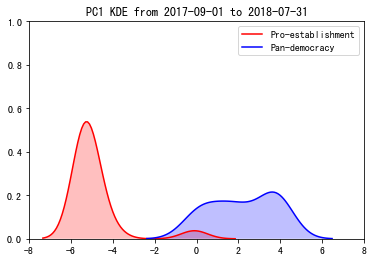

In [57]:
visualize_a_segment(df_main_motions, terms[1][0], terms[1][1])

### 2 years voter preference variation analysis

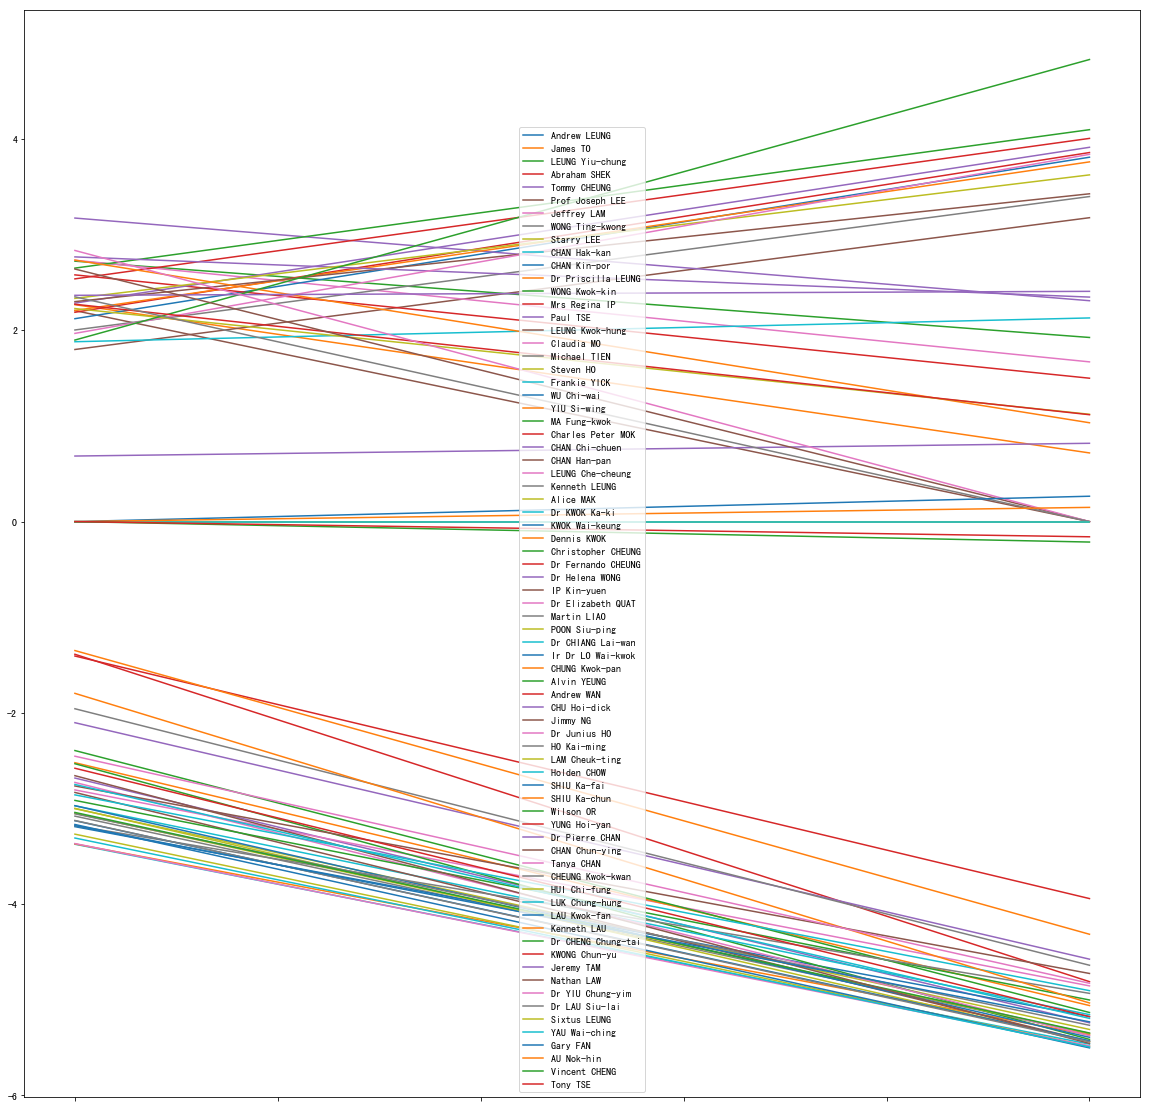

In [58]:
df_variation = pd.DataFrame(index=all_voters)
for t in terms:
    df_main_motions_selected = df_main_motions[
        (df_main_motions['date'] > t[0])
        &
        (df_main_motions['date'] < t[1])
    ]
    X = construct_matrix_from_dataframe(df_main_motions_selected)
    X_PC1 = pca_legco_all.transform(X)
    df_pc1 = construct_dataframe_from_pc1_vector(X_PC1)
    df_pc1.columns = [t]
    df_variation[t] = df_pc1
df_variation.T.plot(figsize=(20, 20))

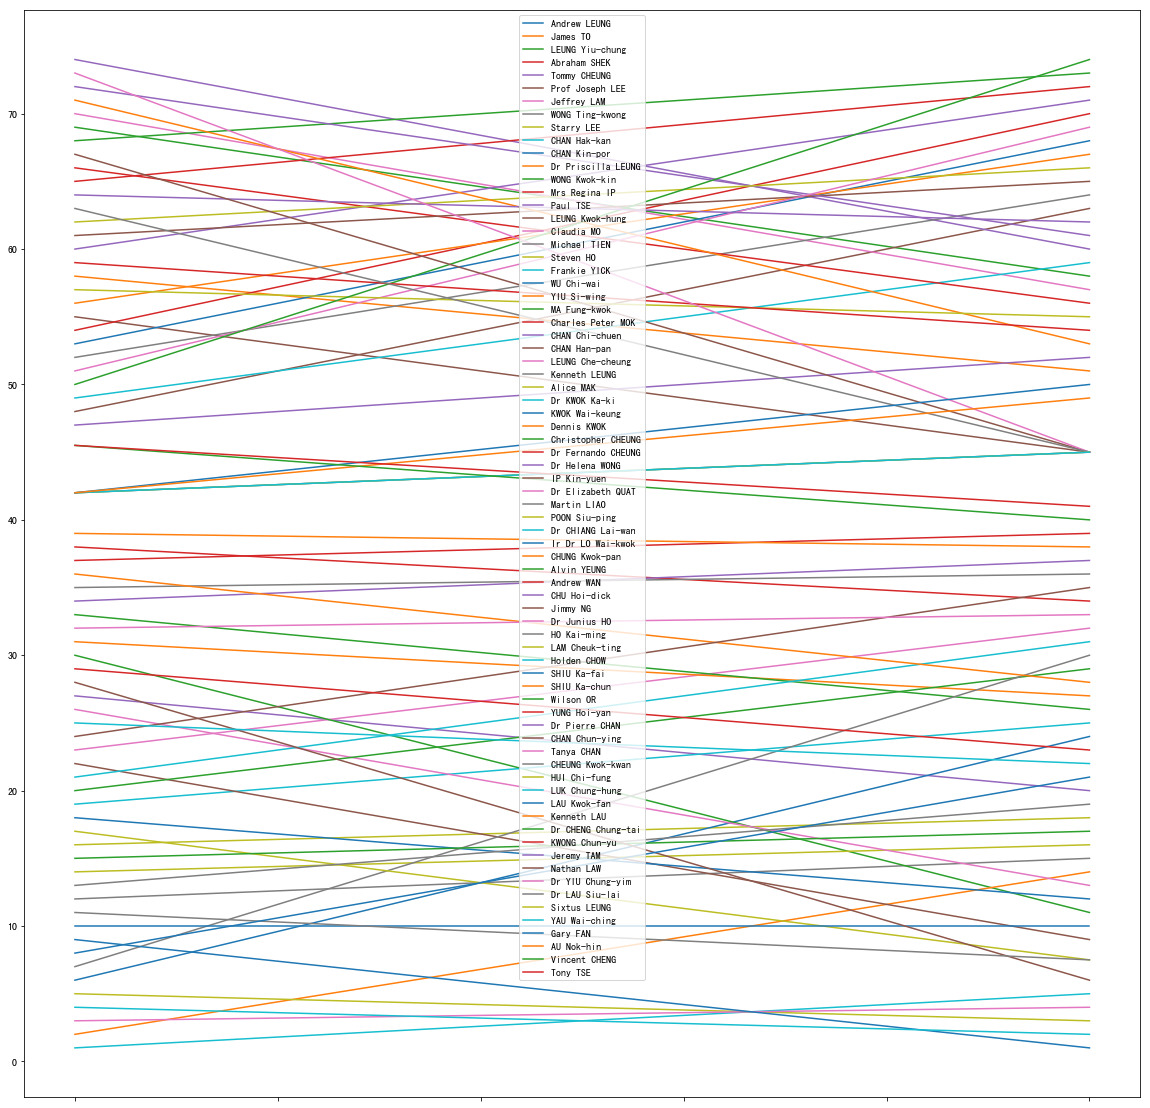

In [59]:
df_variation.rank().T.plot(figsize=(20, 20))


### 2 years voter preference variation analysis - fine granularity

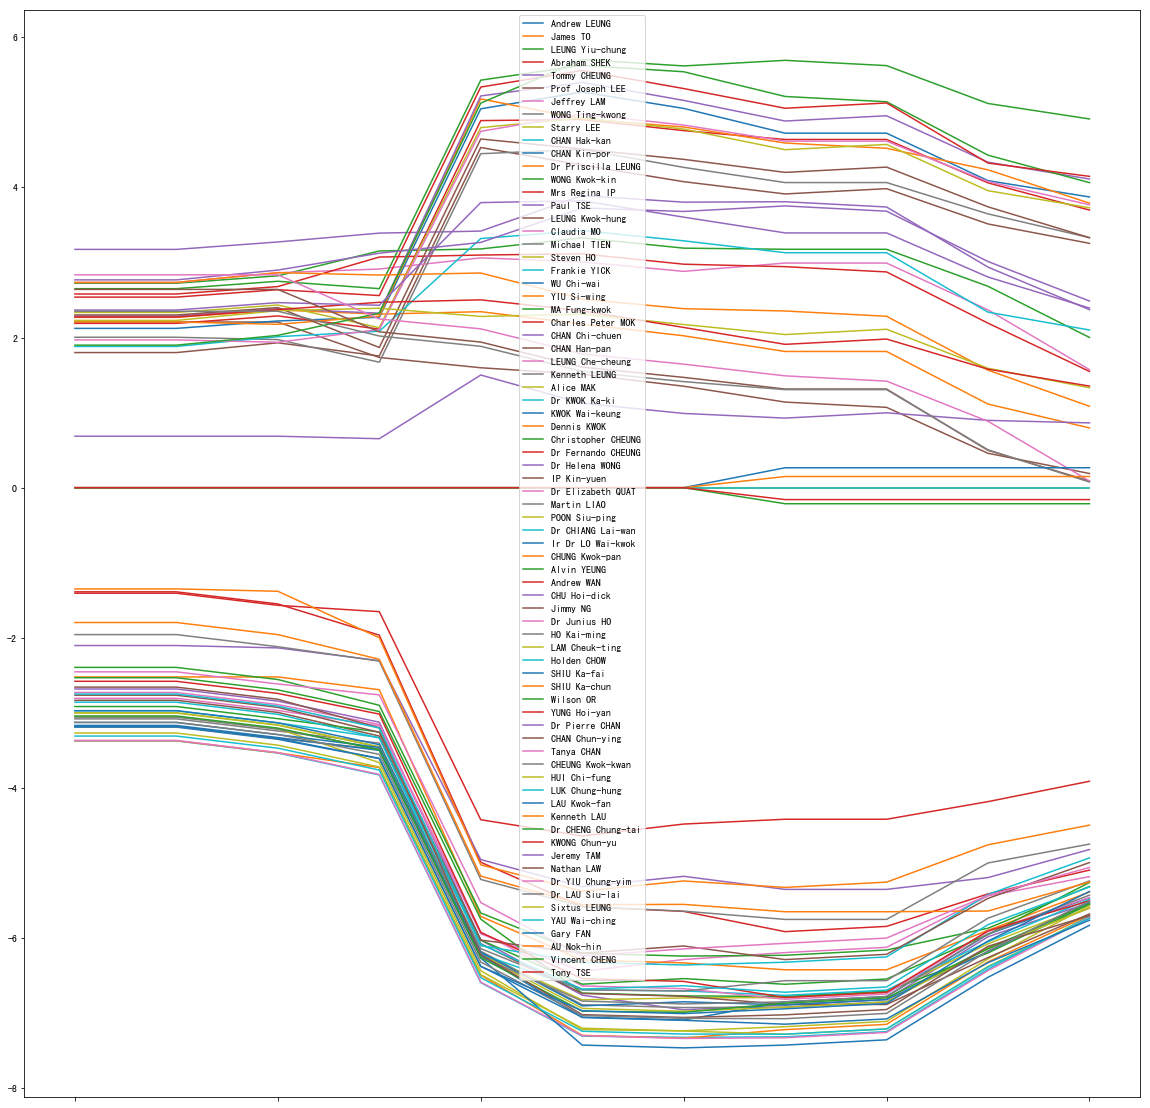

In [60]:
date_begin = date(2016, 9, 1)
date_end = date(2017, 9, 1)
#from dateutil.relativedelta import relativedelta
delta_1month = dateutil.relativedelta.relativedelta(months=1)
df_variation = pd.DataFrame(index=all_voters)
while date_end < date(2018, 7, 31):
    
    df_main_motions_selected = df_main_motions[
        (df_main_motions['date'] > date_begin)
        &
        (df_main_motions['date'] < date_end)
    ]
    #print(date_begin, date_end, len(df_main_motions_selected))
    X = construct_matrix_from_dataframe(df_main_motions_selected)
    X_PC1 = pca_legco_all.transform(X)
    df_pc1 = construct_dataframe_from_pc1_vector(X_PC1)
    t = (date_begin, date_end)
    df_pc1.columns = [t]
    df_variation[t] = df_pc1
    date_begin += delta_1month
    date_end += delta_1month
    
df_variation.T.plot(figsize=(20, 20))


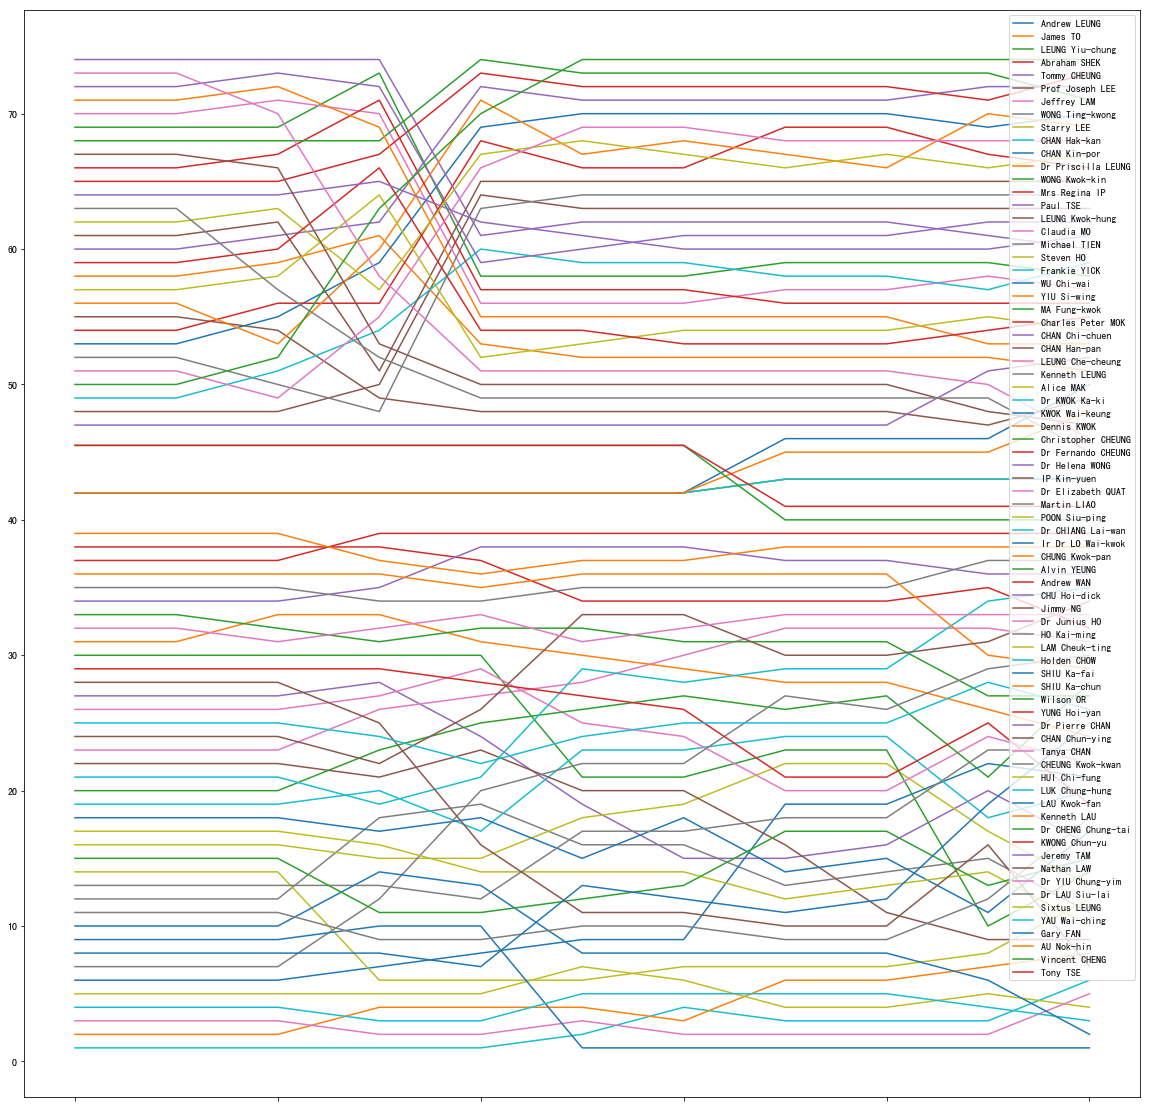

In [61]:
df_variation.rank().T.plot(figsize=(20, 20))


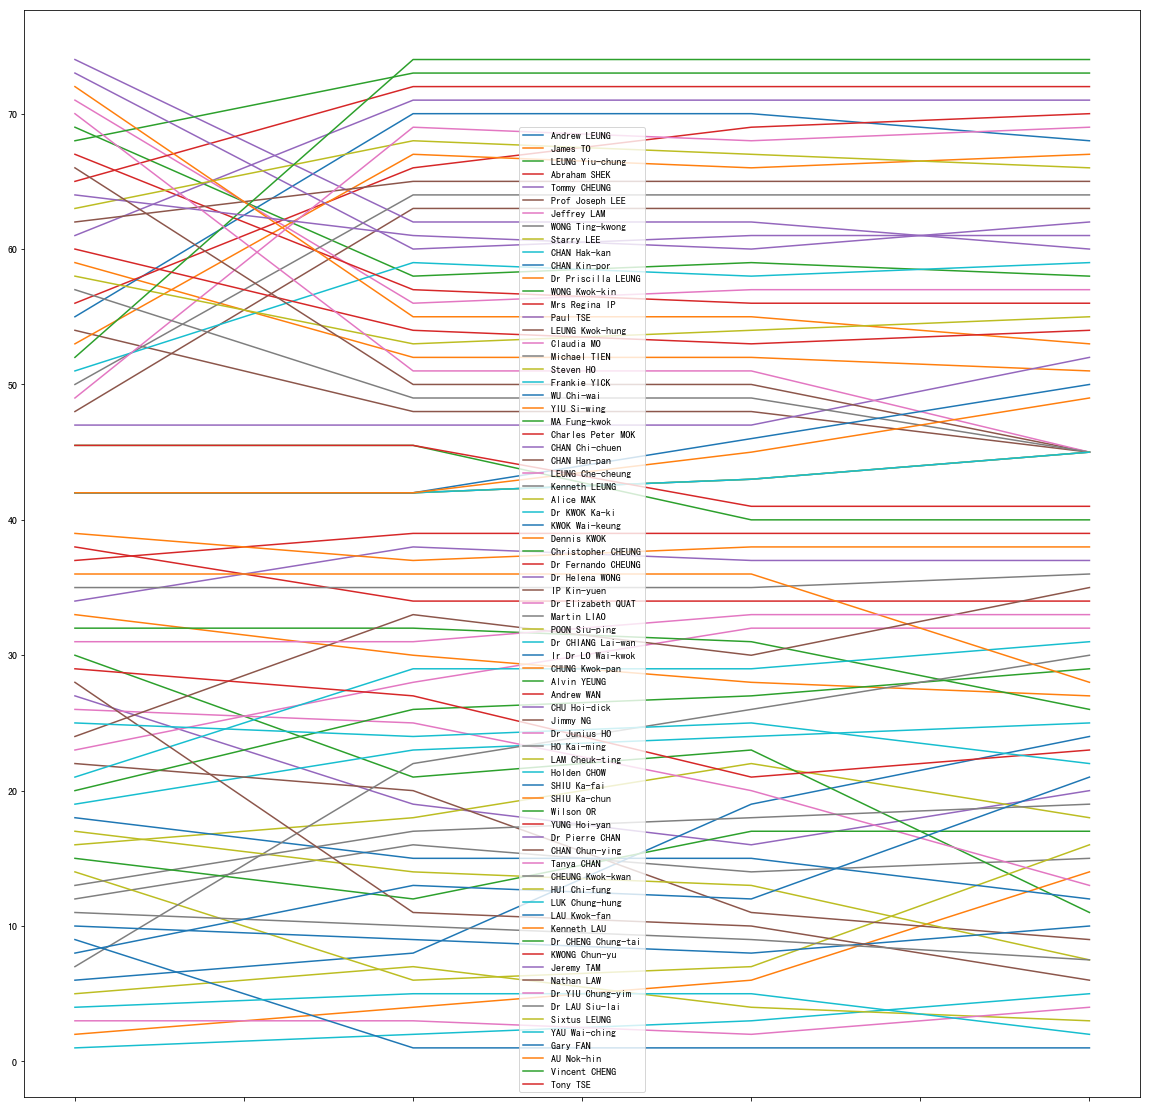

In [62]:
date_begin = date(2016, 10, 31)
date_end = date(2017, 10, 31)
#from dateutil.relativedelta import relativedelta
delta_month = dateutil.relativedelta.relativedelta(months=3)
df_variation = pd.DataFrame(index=all_voters)
while date_end < date(2018, 7, 31):
    
    df_main_motions_selected = df_main_motions[
        (df_main_motions['date'] > date_begin)
        &
        (df_main_motions['date'] < date_end)
    ]
    #print(date_begin, date_end, len(df_main_motions_selected))
    X = construct_matrix_from_dataframe(df_main_motions_selected)
    X_PC1 = pca_legco_all.transform(X)
    df_pc1 = construct_dataframe_from_pc1_vector(X_PC1)
    t = (date_begin, date_end)
    df_pc1.columns = [t]
    df_variation[t] = df_pc1
    date_begin += delta_month
    date_end += delta_month

df_variation.rank().T.plot(figsize=(20, 20))


%95 percentile variance: 95.61666666666666


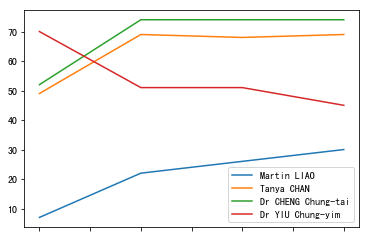

In [63]:
p = 95
percentile = np.percentile(df_variation.rank().T.var(), p)
print('%%%d percentile variance: %s' % (p, percentile))
df_variation.rank()[df_variation.rank().T.var() > percentile].T.plot()
large_variance_members = list(df_variation[df_variation.rank().T.var() > percentile].index)

In [64]:
base_begin = (61, 129, 153)
base_mid = (200, 200, 200)
base_end = (204, 20, 62)
s_member_avg_rank = df_variation.sum(axis=1).rank()
mid_rank = s_member_avg_rank['Andrew LEUNG']
df_member_color = pd.DataFrame()
df_member_color['rank'] = s_member_avg_rank

def linear_interpolate(color_begin, color_end, rank_begin, rank_end, rank):
    color_begin = np.array(color_begin)
    color_end = np.array(color_end)
    color_delta = (color_end - color_begin) / (rank_end - rank_begin)
    color = (color_begin + (rank - rank_begin) * color_delta) / 255.0
    return  tuple(color)

def get_color_for_member(rank):
    if rank <= mid_rank:
        return linear_interpolate(base_begin, base_mid, 1, mid_rank, rank)
    else:
        return linear_interpolate(base_mid, base_end, mid_rank, 74, rank)
    
df_member_color['color'] = s_member_avg_rank.apply(get_color_for_member)
#f_member_color.ix['Andrew LEUNG']['rank']
#f_member_color

In [65]:
df_variation['avg-rank'] = df_member_color['rank']
df_variation = df_variation.sort_values(by='avg-rank')
del df_variation['avg-rank']

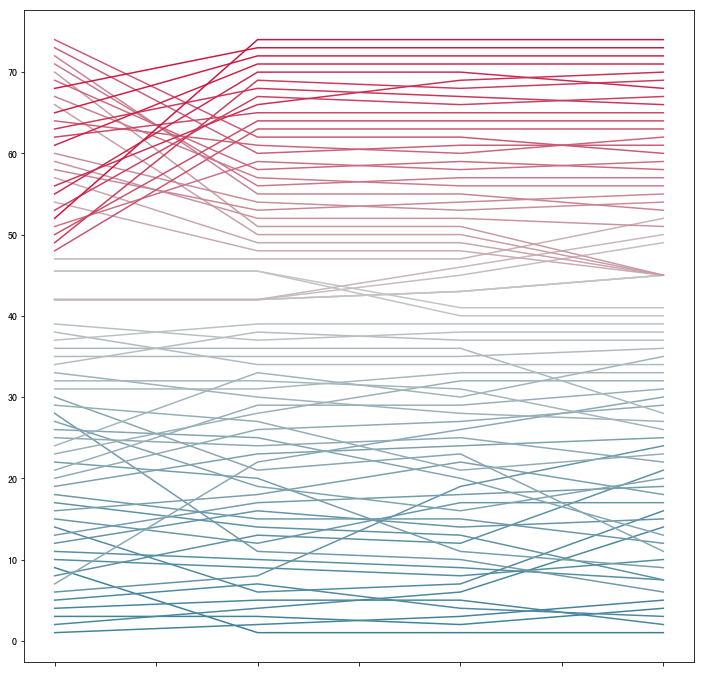

In [66]:
plt.figure(figsize=(12, 12))
i=1
for s in df_variation.rank().T:
    df_variation.rank().T[s].plot(color=get_color_for_member(i))
    #print(get_color_for_member(i))
    i += 1

Text(0.5,1,'histogram of variance of voting preference variation sequences')

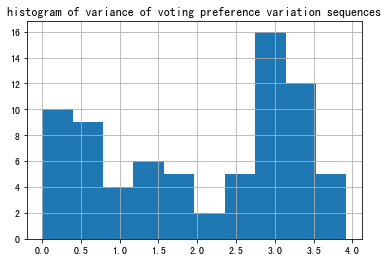

In [67]:
df_variation.T.var().hist()
plt.title('histogram of variance of voting preference variation sequences')

%95 percentile variance: 3.558954058085291


Text(0.5,1,'>95%% percentile variance members')

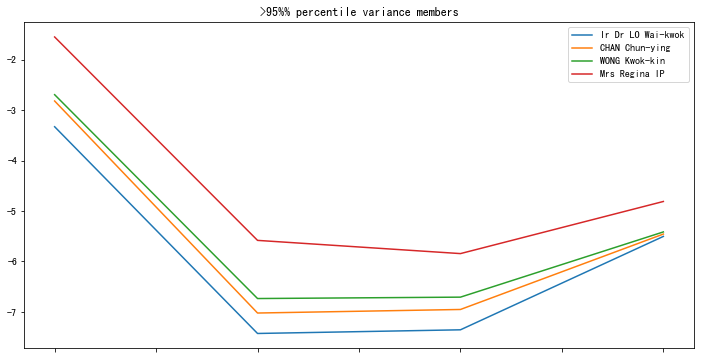

In [68]:
p = 95
percentile = np.percentile(df_variation.T.var(), p)
print('%%%d percentile variance: %s' % (p, percentile))
df_variation[df_variation.T.var() > percentile].T.plot(figsize=(12, 6))
plt.title('>95%% percentile variance members')


%5 percentile variance: 0.008045288536885095


Text(0.5,1,'<5%% percentile variance members')

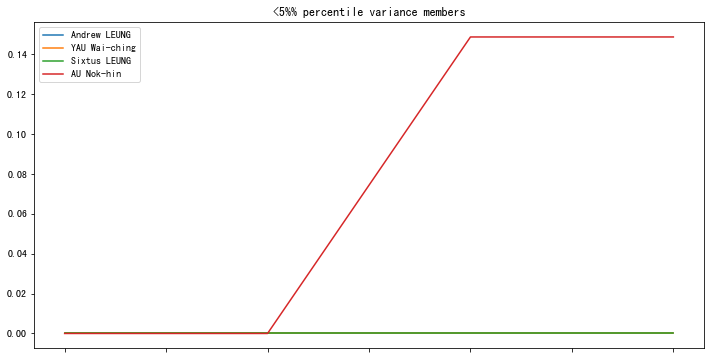

In [69]:
p = 5
percentile = np.percentile(df_variation.T.var(), p)
print('%%%d percentile variance: %s' % (p, percentile))
df_variation[df_variation.T.var() < percentile].T.plot(figsize=(12, 6))
plt.title('<5%% percentile variance members')


## Heatmap

In [70]:
s_belief = []
s_pair = []
for (gname, g) in df.groupby(['mover-en', 'name-en']):
    #print(gname, '\n', g.vote.value_counts())
    value_counts = g.vote.value_counts()
    belief = value_counts.get('Yes', 0) / value_counts.sum()
    s_belief.append(belief)
    s_pair.append(gname)

In [71]:
df_belief = pd.DataFrame(s_belief, index=s_pair, columns = ['belief']).reset_index().fillna(0)
df_belief['mover'] = df_belief['index'].apply(lambda x: x[0])
df_belief['voter'] = df_belief['index'].apply(lambda x: x[1])
# DataFrame.pivot(index=None, columns=None, values=None)
df_belief_matrix = df_belief.pivot('mover', 'voter', 'belief')

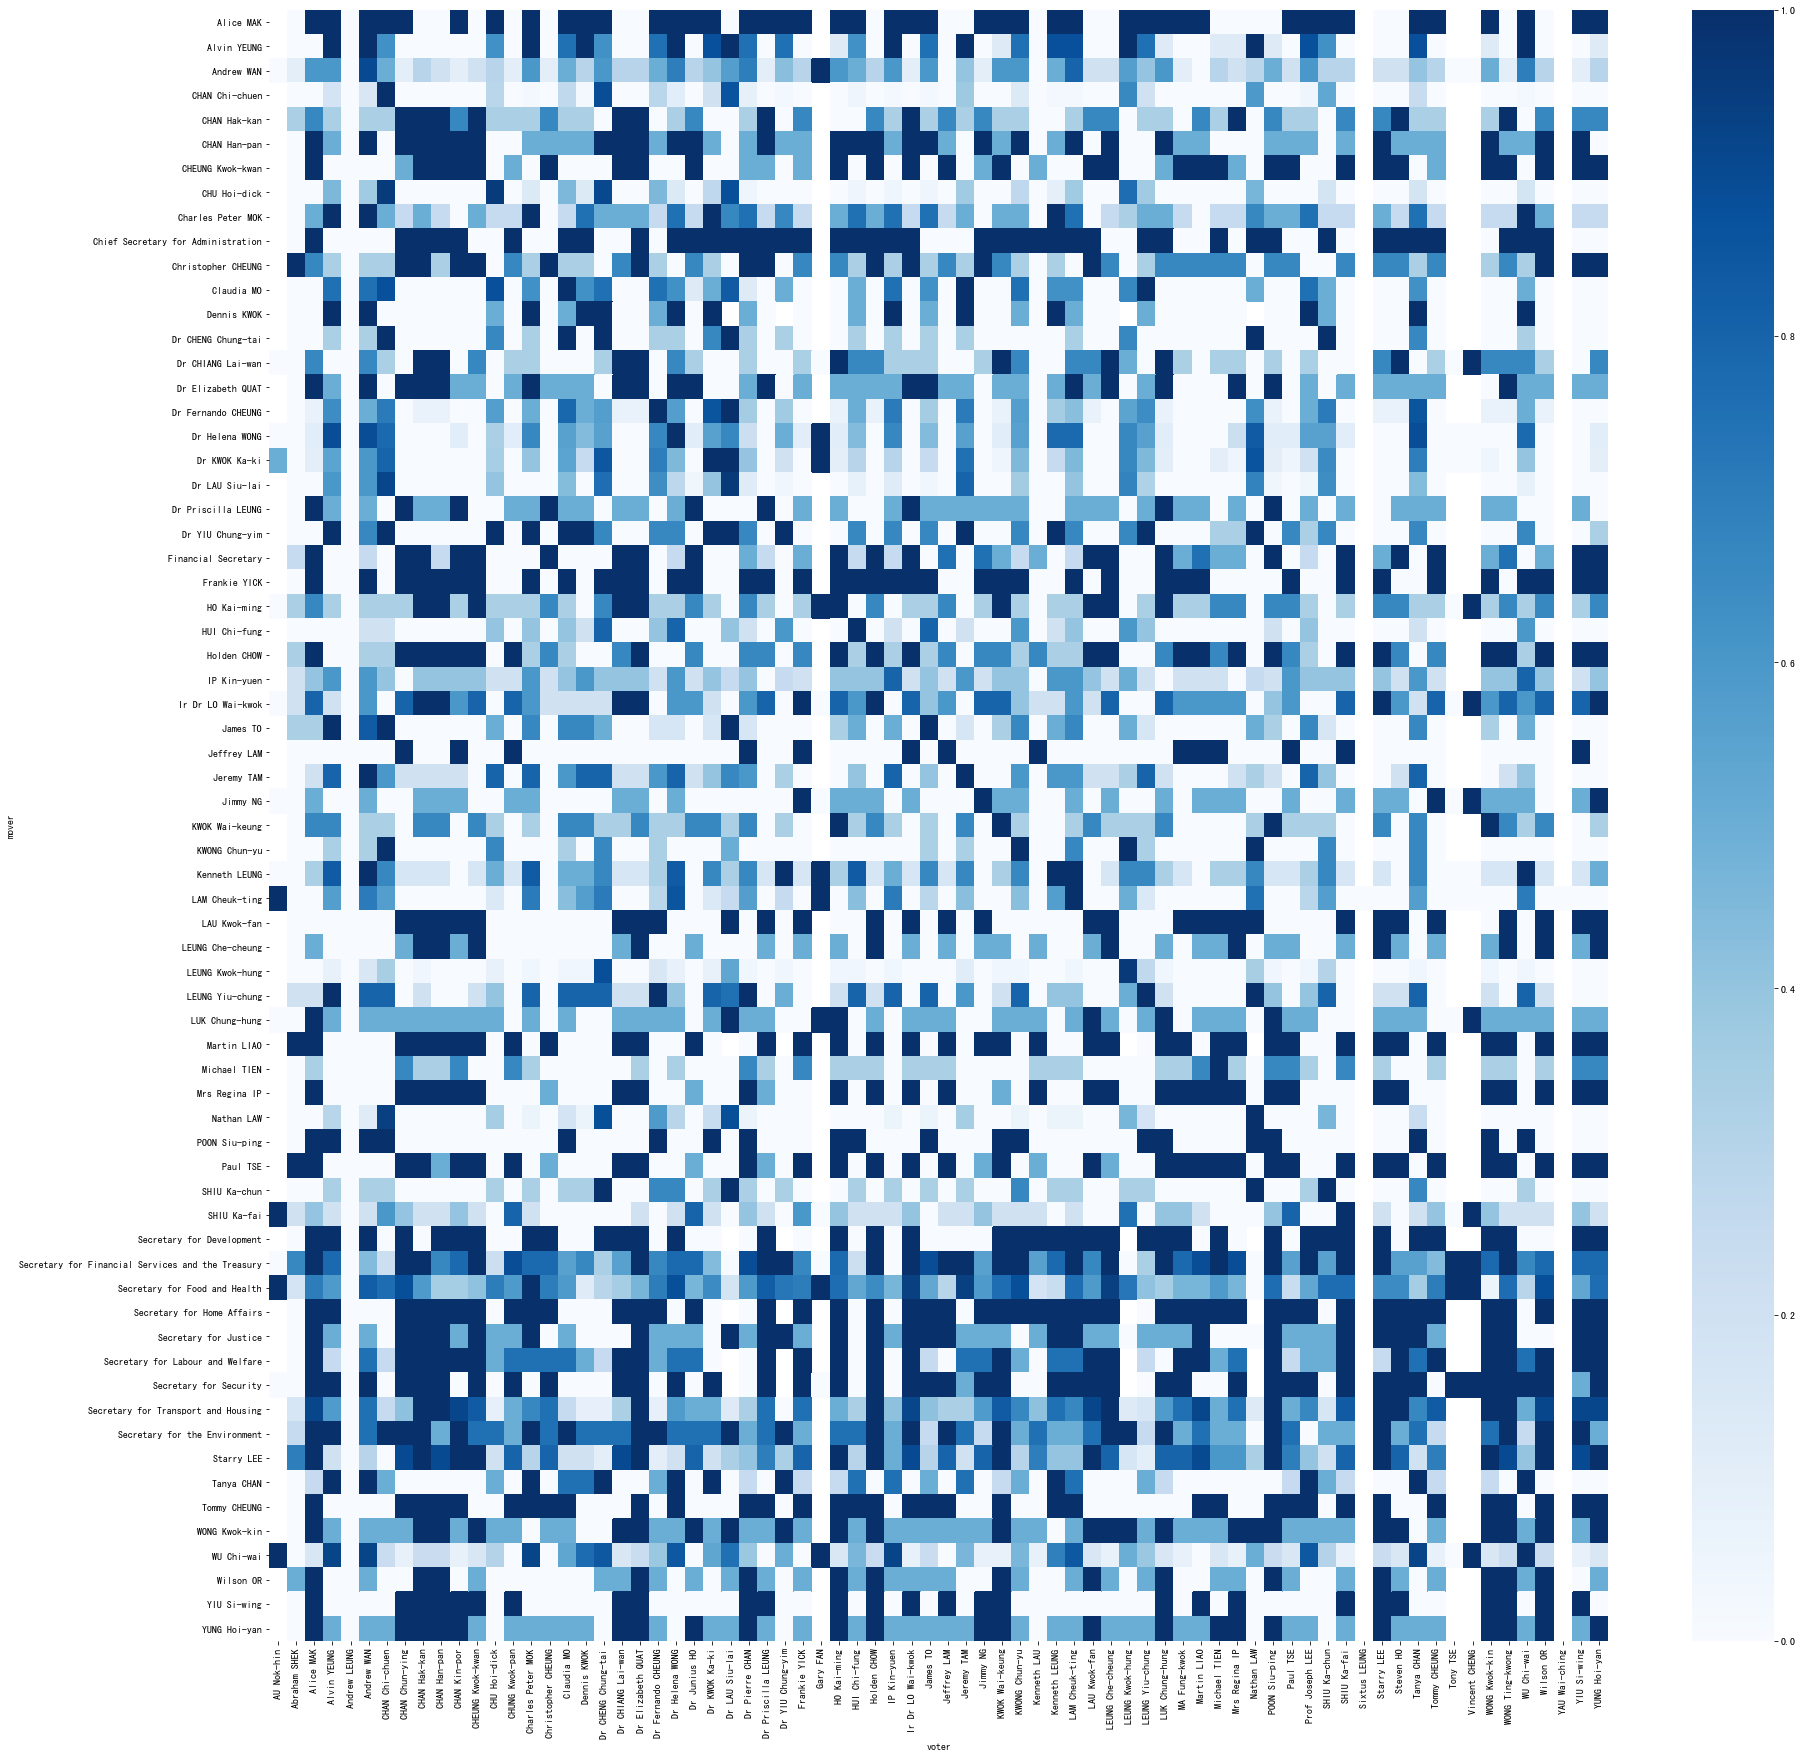

In [72]:
plt.figure(figsize=(30, 30))
sns.heatmap(df_belief_matrix,cmap="Blues")

In [73]:
possible_members = df.member_id.unique()
current_movers = df_belief_matrix.index
set(possible_members) - set(current_movers)

{'AU Nok-hin',
 'Abraham SHEK',
 'Andrew LEUNG',
 'CHAN Chun-ying',
 'CHAN Kin-por',
 'CHUNG Kwok-pan',
 'Dr Junius HO',
 'Dr Pierre CHAN',
 'Gary FAN',
 'Kenneth LAU',
 'MA Fung-kwok',
 'Prof Joseph LEE',
 'Sixtus LEUNG',
 'Steven HO',
 'Tony TSE',
 'Vincent CHENG',
 'WONG Ting-kwong',
 'YAU Wai-ching'}

In [74]:
possible_movers = df[['mover-en', 'mover-ch']].drop_duplicates()

In [75]:
df_pc1 = get_pc1_from_df(df)

In [76]:
#df_pc1

df_belief_matrix = df_belief_matrix.T
for new_mover in set(possible_members) - set(current_movers):
    df_belief_matrix[new_mover] = pd.Series(np.zeros(len(possible_members)), index=df_belief_matrix.index).fillna(0)
df_belief_matrix = df_belief_matrix.T

# Reorder Mover
df_belief_matrix['PC1'] = df_pc1
df_belief_matrix = df_belief_matrix.sort_values('PC1')
del df_belief_matrix['PC1']

# Reorder Voter
df_belief_matrix = df_belief_matrix.T
df_belief_matrix['PC1'] = df_pc1
df_belief_matrix = df_belief_matrix.sort_values('PC1')
del df_belief_matrix['PC1']

# Change back to Mover as index and Voter as column
df_belief_matrix = df_belief_matrix.T

#df_belief_matrix

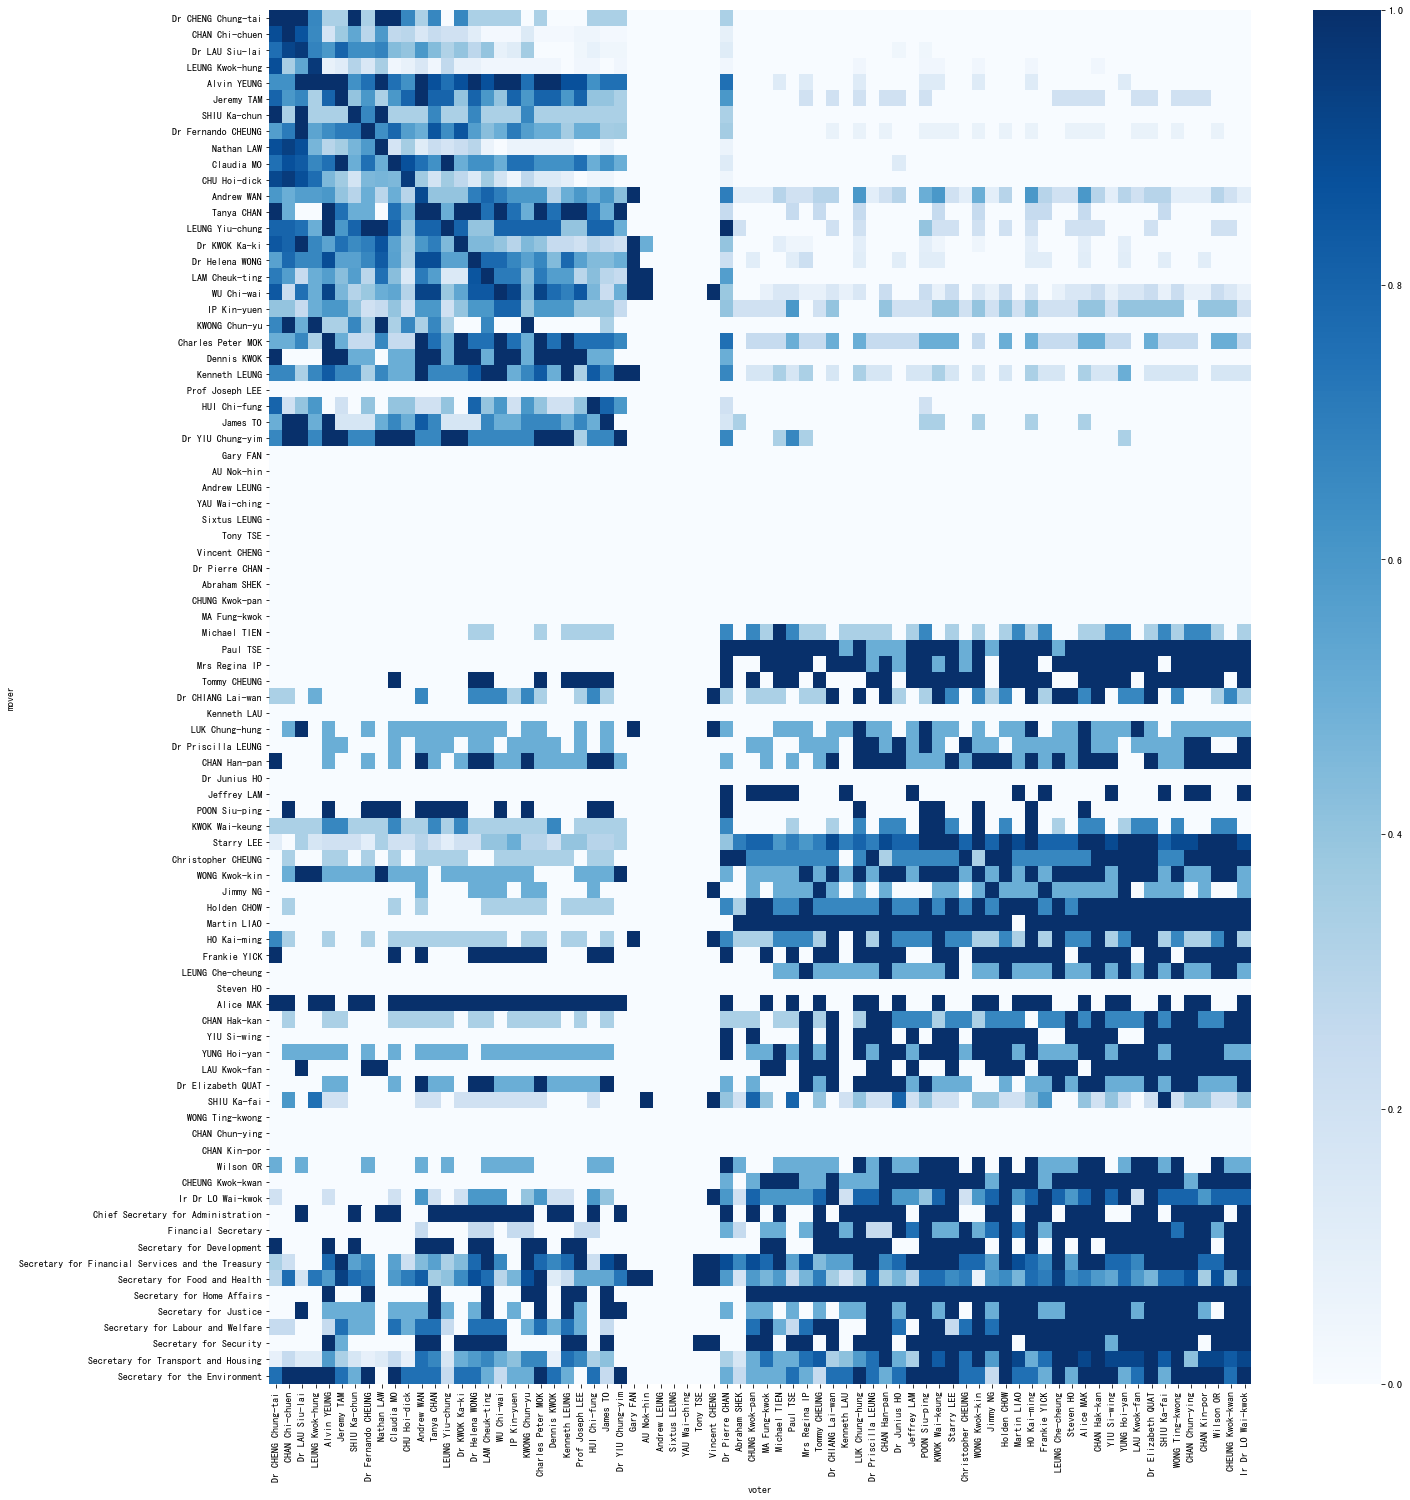

In [77]:
fig_width = 22
fig_height = fig_width / (df_belief_matrix.size / len(df_belief_matrix)) * len(df_belief_matrix)
plt.figure(figsize=(fig_width, fig_height))
sns.heatmap(df_belief_matrix.fillna(0),cmap="Blues")

* 泛民與泛民之間、建制與建制之間相互支持，但是相較而言泛民更加團結（泛民對泛民比建制對建制的光譜顏色更深些）
* 建制基本不同意泛民的提案，但是有些泛民會同意建制的提案
* 泛民與建制都對政府的提案有較大的同意度，但顯然建制對政府的支持更多
* Alice MAK 麥美娟 屬於工聯會，建制派，但受泛民主派支持較多

## Sanity Check

In [78]:
print('Total records in the DataFrame:')
print(len(df))

Total records in the DataFrame:
27426


In [79]:
print('Those columsn in the table:')
print(df.keys())

Those columsn in the table:
Index(['Unnamed: 0', 'topic_id', 'member_id', 'vote', 'name-en', 'name-ch',
       'vote-date', 'vote-time', 'motion-en', 'motion-ch', 'mover-en',
       'mover-ch', 'mover-type', 'vote-separate-mechanism', 'date', 'datetime',
       'year', 'month', 'day', 'vote-value'],
      dtype='object')
